In [1]:
import pymysql
import pandas as pd
import numpy as np
import re
import jieba

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

TENCENT_VECTOR_PATH = '/Users/huan/Desktop/WEIBO_ALL/weibo/word_vector/Tencent_AILab_ChineseEmbedding.txt'
MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 200

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

In [3]:
df = pd.read_sql_query('''
select name, tag from base_goods
union all
select name,tag from base_live_goods 
''', conn)

In [4]:
def find_chinese(file):
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese = re.sub(pattern, '', file)
    return chinese

def replace_puncs(x):
    return re.sub(r'[^\w\s]','',x)

def remove_blanks(x):
    return re.sub(r'\s{2,}','',x)

def cut_text(x):
    return list(jieba.cut(x,cut_all=False))

def preprocess_texts(df):

    df['clean_name'] = df.name.apply(remove_blanks).apply(replace_puncs).apply(find_chinese).values
    df['cutted_text'] = df.clean_name.apply(cut_text).values
    df['texts'] = df.cutted_text.apply(lambda x:' '.join(x)).values
    df.loc[:,'sequence_length'] = df.cutted_text.apply(lambda x:len(x)).values
    df = df[(df.sequence_length >0) & (df.sequence_length <= MAX_SEQUENCE_LENGTH)]
    return df

In [5]:
df = preprocess_texts(df)

Building prefix dict from the default dictionary ...
I0822 18:39:50.979993 4608122304 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0822 18:39:50.984097 4608122304 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.736 seconds.
I0822 18:39:51.719486 4608122304 __init__.py:163] Loading model cost 0.736 seconds.
Prefix dict has been built succesfully.
I0822 18:39:51.721190 4608122304 __init__.py:164] Prefix dict has been built succesfully.


In [6]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df.texts)
num_words = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print('Number of word considered: {}'.format(num_words))
word2index = tokenizer.word_index

Number of word considered: 50000


In [7]:
sequences = tokenizer.texts_to_sequences(df.texts)

In [8]:
padded_sequences = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)

In [9]:
embeddings_index = dict()
with open(TENCENT_VECTOR_PATH,'r', encoding = 'utf-8') as f:
    next(f)
    for line in f:
        values = line.split(' ')
        word = values[0]
        if word in word2index:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, ind in word2index.items():
    if ind < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[ind] = embedding_vector

In [10]:
from keras.layers import Input,Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate,Flatten
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [11]:
nonnull_index = np.where((df.tag != '').values)[0]
features = padded_sequences[nonnull_index]
targets = pd.Categorical(df.iloc[nonnull_index,:]['tag'])
idx_to_cat = {idx:cat for idx, cat in enumerate(pd.Categorical(targets.categories))}
targets = targets.codes
K = max(idx_to_cat) + 1

In [12]:
embedding_layer = Embedding(num_words,
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(input_dim=num_words, output_dim=200, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix],trainable=False)(inputs)
l_conv01 = Conv1D(128, 3,activation='relu',padding='same')(embedded_sequences)
l_pool01 = MaxPooling1D(3)(l_conv01)
l_conv02 = Conv1D(128, 4,activation='relu',padding='same')(embedded_sequences)
l_pool02 = MaxPooling1D(5)(l_conv02)
l_conv03 = Conv1D(128, 5,activation='relu',padding='same')(embedded_sequences)
l_pool03 = MaxPooling1D(5)(l_conv03)
l_merge = concatenate([l_pool01,l_pool02,l_pool03],axis=1)

l_cov2 = Conv1D(128, 3, activation='relu',padding='same')(l_merge)
l_pool2 = MaxPooling1D(10)(l_cov2)
l_pool2 = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_pool2)
encoder = Model(inputs, l_dense)

encoded_vector = encoder(inputs)

preds = Dense(K, activation='softmax')(encoded_vector)

model=Model(inputs,preds)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [13]:
from keras.utils import plot_model

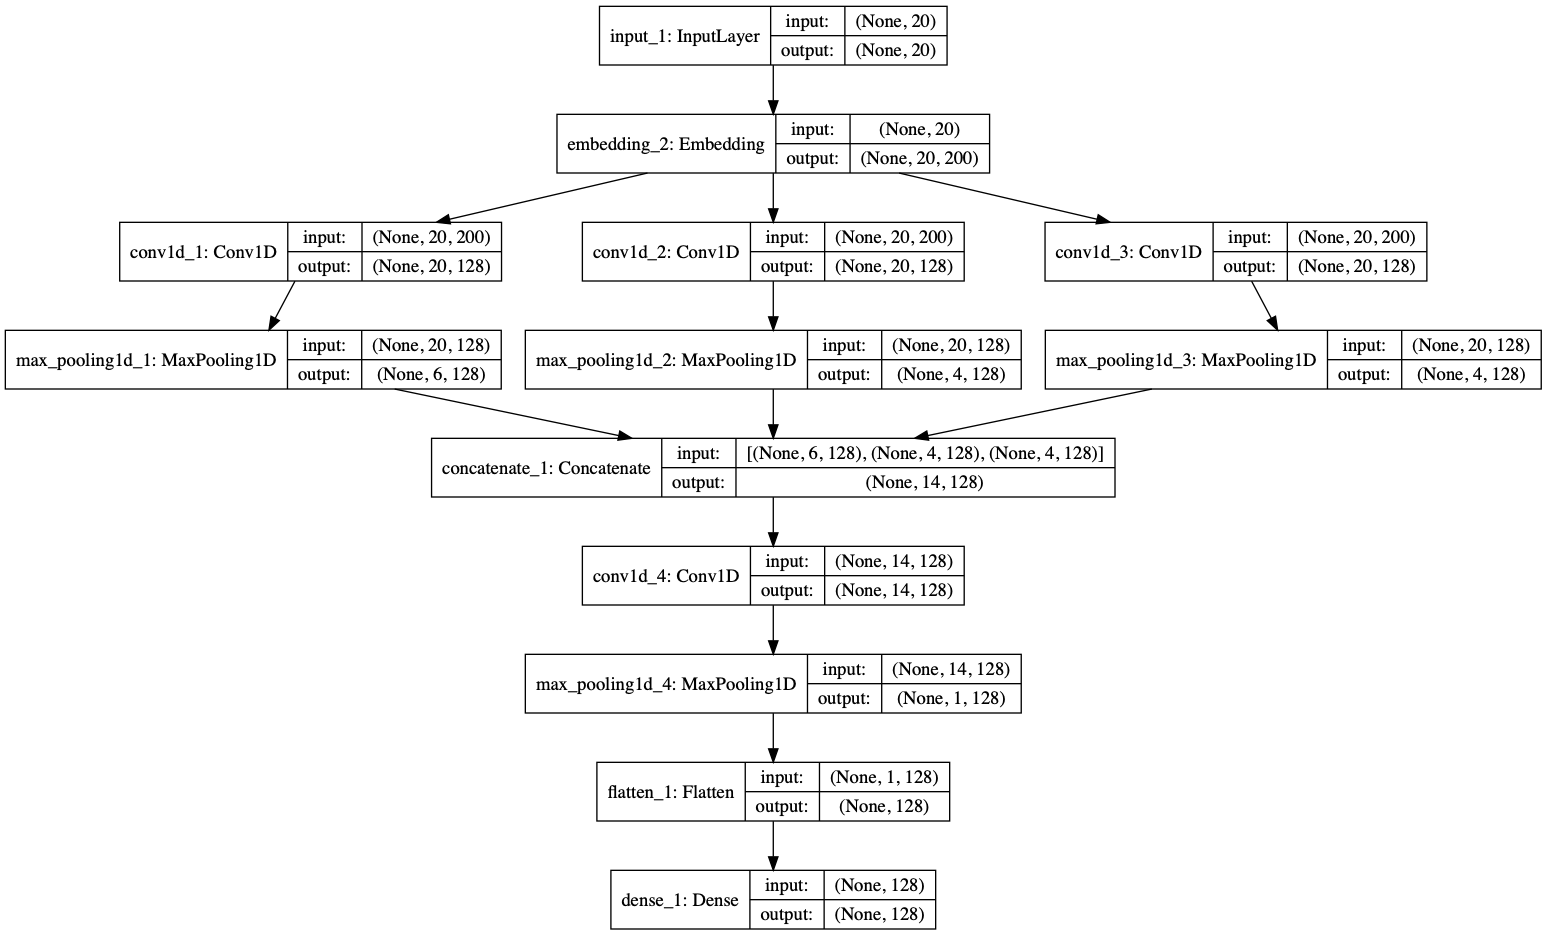

In [14]:
plot_model(encoder,show_shapes=True)

In [15]:
model.fit(features, targets,batch_size =128,epochs = 7,validation_split = 0.3)

Train on 366926 samples, validate on 157255 samples
Epoch 1/7
366926/366926 [==============================] - 101s 276us/step - loss: 0.3386 - accuracy: 0.8998 - val_loss: 0.3735 - val_accuracy: 0.8886
Epoch 2/7
366926/366926 [==============================] - 103s 280us/step - loss: 0.1846 - accuracy: 0.9456 - val_loss: 0.3466 - val_accuracy: 0.8991
Epoch 3/7
366926/366926 [==============================] - 112s 307us/step - loss: 0.1429 - accuracy: 0.9573 - val_loss: 0.3356 - val_accuracy: 0.9077
Epoch 4/7
366926/366926 [==============================] - 106s 289us/step - loss: 0.1164 - accuracy: 0.9647 - val_loss: 0.3252 - val_accuracy: 0.9141
Epoch 5/7
366926/366926 [==============================] - 103s 282us/step - loss: 0.0987 - accuracy: 0.9692 - val_loss: 0.3495 - val_accuracy: 0.9089
Epoch 6/7
366926/366926 [==============================] - 110s 300us/step - loss: 0.0851 - accuracy: 0.9732 - val_loss: 0.3796 - val_accuracy: 0.9101
Epoch 7/7
366926/366926 [=================

In [16]:
padded_sequences = pad_sequences(tokenizer.texts_to_sequences(preprocess_texts(df[df.tag == '']).texts), maxlen = MAX_SEQUENCE_LENGTH)
preds = model.predict(padded_sequences).argmax(axis = 1)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [17]:
tmp = df[df.tag == '']

In [18]:
tmp['predictions'] = [idx_to_cat[p] for p in preds]

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
encoder.predict(padded_sequences).shape

(195692, 128)

In [20]:
tmp.head(100)

name tag  \
1                       【橙子快跑】无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐600g       
3                       东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器       
6               WRZ i7耳机原装正品适用苹果6s华为oppo小米vivo入耳式有线高音质       
15                      一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套       
16                  工装短裤女高腰夏宽松2019新款韩版显瘦bf风休闲潮ins五分裤外穿       
..                                                 ...  ..   
670                        【集呈】现代简约圆形人体感应小夜灯光控橱柜灯智能小夜灯       
675                        【集呈】现代简约圆形人体感应小夜灯光控橱柜灯智能小夜灯       
680                      【一盒12片装】洗衣机清洗剂去污渍家用滚筒式洗衣机槽泡腾片       
681  闪魔苹果8plus手机壳iphone7气囊防摔保护套7p8p透明硅胶软壳6s潮牌女男6p网红...       
684                     马油护脚霜皲裂愈合膏脚后跟干裂脱皮脚裂膏脚后跟龟裂手裂口修复       

                         clean_name  \
1          橙子快跑无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐   
3    东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器   
6            耳机原装正品适用苹果华为小米入耳式有线高音质   
15   一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套   
16        工装短裤女高腰夏宽松新款韩版显瘦风休闲潮五分裤外穿   
..                              ...   
670       集呈现代简约圆形人体感应小夜灯光控橱柜灯智能小夜灯   
675       集呈现代简约圆形人体感应小夜灯光控橱柜灯智能小夜灯   
680       一盒片装洗衣机清洗剂去污渍家用滚筒式洗衣机槽泡腾片   
681      闪魔苹果手机壳气囊防摔保护套透明硅胶软壳潮牌女男网红   
684  马油护脚霜皲裂愈合膏脚后跟干裂脱皮脚裂膏脚后跟龟裂手裂口修复   

                                           cutted_text  \
1    [橙子, 快, 跑, 无, 蔗糖, 全麦, 面包, 南瓜, 藜, 麦, 健康, 粗纤, 健身...   
3    [东菱, 早餐, 机, 多功能, 三合, 一家, 用, 三明治, 宿舍, 锅, 学生, 锅,...   
6           [耳机, 原装, 正品, 适用, 苹果, 华为, 小米, 入耳式, 有线, 高音质]   
15   [一次性, 洗脸, 巾, 纯棉, 压缩, 毛巾, 旅行装, 浴巾, 女, 旅游, 酒店用品,...   
16   [工装, 短裤, 女高, 腰夏, 宽松, 新款, 韩版显, 瘦风, 休闲, 潮, 五分裤, 外穿]   
..                                                 ...   
670  [集, 呈, 现代, 简约, 圆形, 人体, 感应, 小夜灯, 光控, 橱柜, 灯, 智能,...   
675  [集, 呈, 现代, 简约, 圆形, 人体, 感应, 小夜灯, 光控, 橱柜, 灯, 智能,...   
680    [一盒, 片装, 洗衣机, 清洗剂, 去, 污渍, 家用, 滚筒式, 洗衣机, 槽, 泡腾片]   
681  [闪魔, 苹果, 手机, 壳, 气囊, 防, 摔, 保护套, 透明, 硅胶, 软壳, 潮牌,...   
684  [马油护, 脚霜, 皲裂, 愈合, 膏, 脚后跟, 干裂, 脱皮, 脚裂膏, 脚后跟, 龟裂...   

                                              texts  sequence_length  \
1            橙子 快 跑 无 蔗糖 全麦 面包 南瓜 藜 麦 健康 粗纤 健身 代 早餐               15   
3    东菱 早餐 机 多功能 三合 一家 用 三明治 宿舍 锅 学生 锅 电热 煮 锅 懒人 神器               17   
6                   耳机 原装 正品 适用 苹果 华为 小米 入耳式 有线 高音质               10   
15      一次性 洗脸 巾 纯棉 压缩 毛巾 旅行装 浴巾 女 旅游 酒店用品 便携 床单 枕套               14   
16             工装 短裤 女高 腰夏 宽松 新款 韩版显 瘦风 休闲 潮 五分裤 外穿               12   
..                                              ...              ...   
670           集 呈 现代 简约 圆形 人体 感应 小夜灯 光控 橱柜 灯 智能 小夜灯               13   
675           集 呈 现代 简约 圆形 人体 感应 小夜灯 光控 橱柜 灯 智能 小夜灯               13   
680             一盒 片装 洗衣机 清洗剂 去 污渍 家用 滚筒式 洗衣机 槽 泡腾片               11   
681        闪魔 苹果 手机 壳 气囊 防 摔 保护套 透明 硅胶 软壳 潮牌 女 男网 红               15   
684     马油护 脚霜 皲裂 愈合 膏 脚后跟 干裂 脱皮 脚裂膏 脚后跟 龟裂 手 裂口 修复               14   

    predictions  
1            食品  
3            百货  
6            手机  
15           百货  
16           女装  
..          ...  
670          家装  
675          家装  
680          百货  
681          手机  
684          百货  

[100 rows x 7 columns]

In [21]:
import pickle
import json
import os

In [22]:
model_config = {"EMBEDDING_DIM":EMBEDDING_DIM, 'num_words':num_words,'MAX_SEQUENCE_LENGTH':MAX_SEQUENCE_LENGTH,'K':K}

In [23]:
np.save('/Users/huan/Desktop/delidou/item_embedding/resources/embedding_matrix.npy',embedding_matrix)
pickle.dump(tokenizer,open('/Users/huan/Desktop/delidou/item_embedding/resources/tokenizer.pkl','wb'))
model.save_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_embedding_model.h5')
encoder.save_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.h5')
model.save('/Users/huan/Desktop/delidou/item_embedding/resources/item_type_prediction_model.h5')
encoder.save('/Users/huan/Desktop/delidou/item_embedding/resources/encoder_model.h5')
pickle.dump(model_config, open('/Users/huan/Desktop/delidou/item_embedding/resources/model_config.pkl','wb'))
pickle.dump(idx_to_cat, open('/Users/huan/Desktop/delidou/item_embedding/resources/idx_to_cat.pkl','wb'))
encoder_json = encoder.to_json()
json.dump(encoder_json,open('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.json','w'))

In [24]:
from keras.models import model_from_json
loaded_model = model_from_json(json.loads(open('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.json').read()))
loaded_model.load_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.h5')

In [25]:
loaded_model.predict(padded_sequences)

array([[0.        , 0.24745461, 0.        , ..., 5.2625623 , 0.37273768,
        3.0653856 ],
       [0.        , 0.46644214, 0.        , ..., 6.698483  , 0.08409469,
        3.5322225 ],
       [0.        , 0.        , 0.8412639 , ..., 4.63421   , 0.        ,
        4.9962454 ],
       ...,
       [0.        , 0.26842758, 1.9732729 , ..., 1.5803921 , 0.6062504 ,
        3.8870723 ],
       [0.        , 0.        , 6.029258  , ..., 5.4804773 , 1.8756485 ,
        7.7990303 ],
       [0.        , 0.        , 0.        , ..., 3.319295  , 0.919748  ,
        1.1036861 ]], dtype=float32)